# Laboratorium 2

## Sekcje 1-5

In [1]:
import duckdb
db = duckdb.connect("data-hw/duckdb_trains.db")

In [2]:
db.sql(
"""
CREATE TABLE IF NOT EXISTS stations AS
FROM "data-hw/stations-2023-09.csv"
"""
)

In [3]:
db.sql(
"""
CREATE TABLE IF NOT EXISTS distances AS
FROM read_csv('data-hw/tariff-distances-2022-01.csv', nullstr = 'XXX');
"""
)

db.sql(
    """
    CREATE TABLE IF NOT EXISTS distances_long AS
    UNPIVOT distances
    ON COLUMNS (* EXCLUDE station)
    INTO NAME other_station VALUE distance;
    """
)

In [4]:
db.sql("""
FROM (DESCRIBE distances)
LIMIT 5;
""")

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Station     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ AC          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AH          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHP         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHPR        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
└─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [5]:
db.sql("""
FROM (DESCRIBE distances_long)
LIMIT 5;
""")

┌───────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name  │ column_type │  null   │   key   │ default │  extra  │
│    varchar    │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Station       │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ other_station │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ distance      │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
└───────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [6]:
db.sql(f"""ATTACH IF NOT EXISTS 'host=localhost user=postgres password=postgres dbname=postgres' AS postgres_db (TYPE postgres);""")
db.sql(
f"""
CREATE TABLE IF NOT EXISTS postgres_db.disruptions AS
FROM read_csv({[f"data-hw/disruptions-{y}.csv" for y in range(2011, 2024)]})
"""
)
db.sql("DESCRIBE postgres_db.disruptions")

┌──────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│     column_name      │ column_type │  null   │   key   │ default │  extra  │
│       varchar        │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ rdt_id               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ ns_lines             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_lines            │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_lines_id         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_station_names    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_station_codes    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ cause_nl             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ cause_en             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ statistical_cause_nl │ VARCHAR     │ YES     │ NUL

In [7]:
duckdb.sql(
f"""
COPY (SELECT * FROM read_csv({[f"data-hw/services-{year}.csv" for year in range(2019, 2023)]}))
TO "data-hw/services_duckdb.parquet" (FORMAT "PARQUET", COMPRESSION "ZSTD")
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
db.sql("""
CREATE TABLE IF NOT EXISTS services AS
FROM "data-hw/services_duckdb.parquet"
""")

## Sekcja 7

How many trains departed from Amsterdam Central station overall?

In [9]:
db.sql(
"""
SELECT COUNT(*) as num_departures
FROM services
WHERE  "Stop:Station name" = 'Amsterdam Centraal' AND "Stop:Departure time" IS NOT NULL
"""
)

┌────────────────┐
│ num_departures │
│     int64      │
├────────────────┤
│        1136365 │
└────────────────┘

Calculate the average arrival delay of different service types (Service:Type). Order results descending by average delay.

In [10]:
db.sql(
"""
SELECT
    "Service:Type",
    ROUND(AVG(COALESCE("Stop:Arrival delay", 0)), 2) AS average_arrival_delay
FROM services
GROUP BY "Service:Type"
ORDER BY average_arrival_delay DESC
"""
)

┌──────────────────────┬───────────────────────┐
│     Service:Type     │ average_arrival_delay │
│       varchar        │        double         │
├──────────────────────┼───────────────────────┤
│ Alpen Express        │                 21.96 │
│ Nachttrein           │                 15.48 │
│ Krokus Express       │                 11.38 │
│ Nightjet             │                  8.01 │
│ Thalys               │                  4.22 │
│ Int. Trein           │                  3.92 │
│ ICE International    │                   3.9 │
│ Eurostar             │                  3.27 │
│ Stoomtrein           │                  1.58 │
│ RE 19                │                  1.47 │
│   ·                  │                    ·  │
│   ·                  │                    ·  │
│   ·                  │                    ·  │
│ Speciale Trein       │                  0.29 │
│ Metro                │                   0.0 │
│ Metro i.p.v. trein   │                   0.0 │
│ stoptrein         

What was the most common disruption cause in different years? MODE function may be useful.

In [11]:
db.sql(
"""
SELECT
    MODE("cause_en"),
    EXTRACT(YEAR FROM "start_time") AS year,
FROM postgres_db.disruptions
GROUP BY year
ORDER BY year
"""
)

┌───────────────────┬───────┐
│ "mode"(cause_en)  │ year  │
│      varchar      │ int64 │
├───────────────────┼───────┤
│ broken down train │  2011 │
│ points failure    │  2012 │
│ points failure    │  2013 │
│ broken down train │  2014 │
│ broken down train │  2015 │
│ broken down train │  2016 │
│ broken down train │  2017 │
│ broken down train │  2018 │
│ broken down train │  2019 │
│ broken down train │  2020 │
│ broken down train │  2021 │
│ broken down train │  2022 │
│ broken down train │  2023 │
├───────────────────┴───────┤
│ 13 rows         2 columns │
└───────────────────────────┘

How many trains started their overall service in any Amsterdam station?

In [12]:
db.sql(
"""
SELECT COUNT(*) as num_trains
FROM services
WHERE
    "Stop:Arrival time" IS NULL
    AND "Stop:Station name" LIKE '%Amsterdam%'
"""
)

┌────────────┐
│ num_trains │
│   int64    │
├────────────┤
│     776834 │
└────────────┘

What fraction of services was run to final destinations outside the Netherlands?

In [13]:
db.sql(
"""
SELECT
    COUNT(*) /
    (SELECT COUNT(*) FROM services WHERE "Stop:Departure time" IS NULL)
    AS num_of_outside_netherlands_services
FROM services
JOIN stations ON services."Stop:Station code" = stations.code
WHERE services."Stop:Departure time" IS NULL AND stations.country != 'NL'
"""
)

┌─────────────────────────────────────┐
│ num_of_outside_netherlands_services │
│               double                │
├─────────────────────────────────────┤
│                0.033784204482949234 │
└─────────────────────────────────────┘

What is the largest distance between stations in the Netherlands (code NL)?

In [14]:
db.sql(
"""
SELECT
    s1.name_long AS station1,
    s2.name_long AS station2,
    dl.distance
FROM distances_long AS dl, stations AS s1, stations AS s2
WHERE dl.station = s1.code
  AND dl.other_station = s2.code
  AND s1.country = 'NL'
  AND s2.country = 'NL'
ORDER BY dl.distance DESC
LIMIT 1;
"""
)

┌────────────┬───────────┬──────────┐
│  station1  │ station2  │ distance │
│  varchar   │  varchar  │  int64   │
├────────────┼───────────┼──────────┤
│ Vlissingen │ Eemshaven │      426 │
└────────────┴───────────┴──────────┘

Compare the average arrival delay between different train operators (Service:Company) on a bar plot. Sort them appropriately.

In [15]:
delays = db.sql(
    """
SELECT
    "Service:Company" AS company,
    AVG(COALESCE("Stop:Arrival delay", 0)) AS avg_arrival_delay
FROM services
WHERE company IS NOT NULL AND company != '.'
GROUP BY "Service:Company"
ORDER BY avg_arrival_delay DESC
LIMIT 10
"""
)
delays

┌────────────┬────────────────────┐
│  company   │ avg_arrival_delay  │
│  varchar   │       double       │
├────────────┼────────────────────┤
│ Railexpert │ 10.493312352478364 │
│ TCS        │  9.595505617977528 │
│ Rail2U     │  5.412532637075718 │
│ NS Int     │ 3.6795119450904834 │
│ VIAS       │  2.042421466717918 │
│ ABRN       │ 1.2747112602274995 │
│ ZLSM       │ 1.1578947368421053 │
│ Eurobahn   │ 0.9948687696279379 │
│ NMBS       │ 0.7647644070915369 │
│ Railpromo  │ 0.7194860813704497 │
├────────────┴────────────────────┤
│ 10 rows               2 columns │
└─────────────────────────────────┘

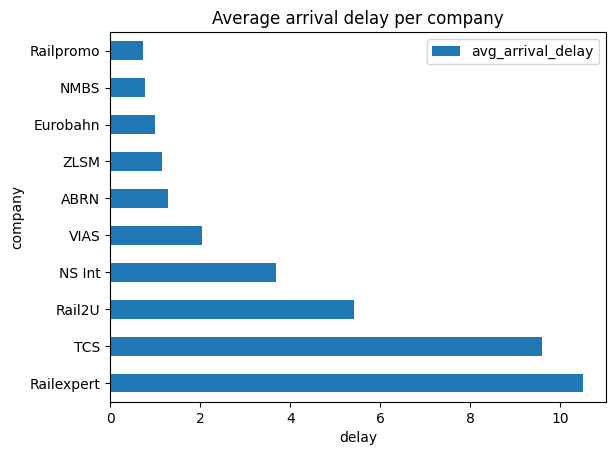

In [16]:
df = delays.df()

df.head(10).plot.barh(
    x="company",
    y="avg_arrival_delay",
    xlabel="delay",
    title="Average arrival delay per company",
);

How many services were disrupted in different years? Make a line plot.

In [17]:
disruptions = db.sql(
"""
SELECT
    EXTRACT(YEAR FROM "start_time") AS year,
    COUNT(*) as num_disruptions
FROM postgres_db.public.disruptions
GROUP BY year
ORDER BY year
"""
)
disruptions

┌───────┬─────────────────┐
│ year  │ num_disruptions │
│ int64 │      int64      │
├───────┼─────────────────┤
│  2011 │            1846 │
│  2012 │            2074 │
│  2013 │            2312 │
│  2014 │            2484 │
│  2015 │            2947 │
│  2016 │            3031 │
│  2017 │            4085 │
│  2018 │            5190 │
│  2019 │            5940 │
│  2020 │            4450 │
│  2021 │            4874 │
│  2022 │            5499 │
│  2023 │            5168 │
├───────┴─────────────────┤
│ 13 rows       2 columns │
└─────────────────────────┘

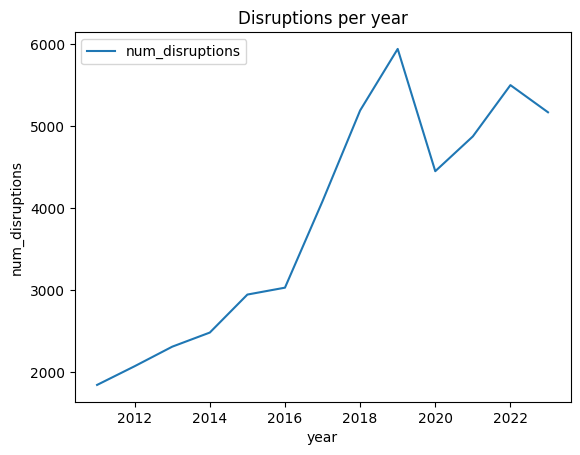

In [18]:
disruptions_df = disruptions.df()
disruptions_df.plot.line(
    x="year",
    y="num_disruptions",
    xlabel="year",
    ylabel="num_disruptions",
    title="Disruptions per year",
);

What fraction of all services were cancelled (Service:Completely cancelled) in different years? Make a line plot.

In [19]:
cancelled = db.sql(
    """
    SELECT
        year,
        cancellation_rate
    FROM (
        SELECT
            EXTRACT(YEAR FROM "Service:Date") AS year,
            COUNT(*) FILTER (WHERE "Service:Completely cancelled" = true) as num_cancelled,
            COUNT(*) AS num_total,
            ROUND(num_cancelled / num_total, 3) AS cancellation_rate
        FROM services
        GROUP BY EXTRACT(YEAR FROM "Service:Date")
    ) AS subquery
    ORDER BY year
    """
)
cancelled

┌───────┬───────────────────┐
│ year  │ cancellation_rate │
│ int64 │      double       │
├───────┼───────────────────┤
│  2019 │             0.011 │
│  2020 │             0.058 │
│  2021 │             0.025 │
│  2022 │             0.043 │
└───────┴───────────────────┘

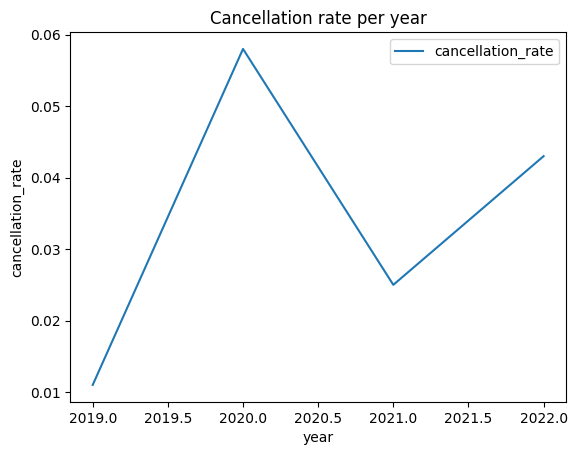

In [20]:
cancelled_df = cancelled.df()

cancelled_df.plot.line(
    x="year",
    y="cancellation_rate",
    xlabel="year",
    ylabel="cancellation_rate",
    title="Cancellation rate per year",
);

## Section 8

Create table station_connections, with columns Service:RDT-ID, start_station_code and end_station_code (pair of stations on a route), and distance between them. Note that you should deduplicate the data on station codes, so that every station pair appears only once. Create temporary tables, use a subquery, or any other similar techniques if necessary.

In [21]:
db.sql(
    """
    SELECT
        s1.name_long AS station1,
        s2.name_long AS station2,
        dl.distance
    FROM distances_long AS dl, stations AS s1, stations AS s2
    WHERE dl.station = s1.code
      AND dl.other_station = s2.code
    ORDER BY dl.distance DESC
    LIMIT 1;
    """
)

┌────────────┬──────────────────┬──────────┐
│  station1  │     station2     │ distance │
│  varchar   │     varchar      │  int64   │
├────────────┼──────────────────┼──────────┤
│ Vlissingen │ Leer (Ostfriesl) │      450 │
└────────────┴──────────────────┴──────────┘

In [31]:
db.sql(
    """
CREATE TABLE IF NOT EXISTS station_connections AS (
    SELECT
        routes."Service:RDT-ID",
        routes.start_station_code,
        routes.end_station_code,
        (
            SELECT distance
            FROM distances_long
            WHERE station = routes.start_station_code
            AND other_station = routes.end_station_code
        ) as distance
    FROM (
        SELECT
            "Service:RDT-ID",
            "Stop:Station code" as start_station_code,
            LEAD("Stop:Station code", 1) OVER (
                PARTITION BY "Service:RDT-ID"
                ORDER BY "Stop:Departure time"
            ) AS end_station_code
        FROM services
    ) routes
    WHERE routes.end_station_code IS NOT NULL
)
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

What is the largest distance between a pair of stations?

In [33]:
db.sql(
"""
SELECT distance
FROM station_connections
ORDER BY distance DESC
LIMIT 1
"""
)

┌──────────┐
│ distance │
│  int64   │
├──────────┤
│      421 │
└──────────┘

Plot a histogram of inter-station distances run by trains.

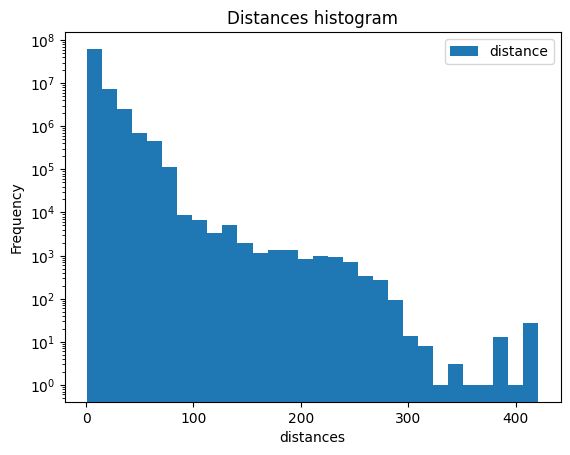

In [40]:
distances_df = db.sql(
    """SELECT distance FROM station_connections"""
).df()
distances_df.plot.hist(
    bins=30,
    xlabel="distances",
    logy=True,
    title="Distances histogram",
);